# Fractional Counts Diagnostics
Notebook to inspect matching between BigQuery output, RegPat filtering, and inventor-country aggregation.

In [14]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = Path('../data')
processed = DATA_DIR / 'processed'
output = DATA_DIR / 'output'
pct_path = processed / 'pct_from_bq.csv'
regpat_path = processed / 'regpat_filtered.parquet'
counts_path = output / 'inventor_country_yearly_fractional_counts.csv'

pct = pd.read_csv(pct_path)
reg = pd.read_parquet(regpat_path)
counts = pd.read_csv(counts_path)
pct['filing_year'] = pct['filing_date'].astype(str).str[:4].astype(int)
matched_pct = pct['pct_nbr'].isin(set(reg['pct_nbr']))
pct['matched'] = matched_pct
pct.head()

,pct_nbr,filing_date,filing_year,matched
0,WO2019202767,20181127,2018,True
1,WO1994026925,19940504,1994,True
2,WO1996001316,19950630,1995,True
3,WO1996028472,19960315,1996,True
4,WO1986004356,19860124,1986,True


In [15]:
reg["ctry_code"].value_counts().sort_values(ascending=False)

ctry_code
US    519861
JP    119664
CN     99268
DE     75866
KR     60045
       ...  
DM         1
TD         1
AW         1
GN         1
TK         1
Name: count, Length: 181, dtype: Int64

## Matched vs unmatched PCT numbers

In [16]:
summary = pct.groupby(['filing_year','matched']).size().unstack(fill_value=0)
summary.tail(10)

matched,False,True
filing_year,,
2016,10,12704
2017,7,13513
2018,3,14378
2019,12,15430
2020,9,16404
2021,54,19036
2022,10,19126
2023,1667,17256
2024,17327,374


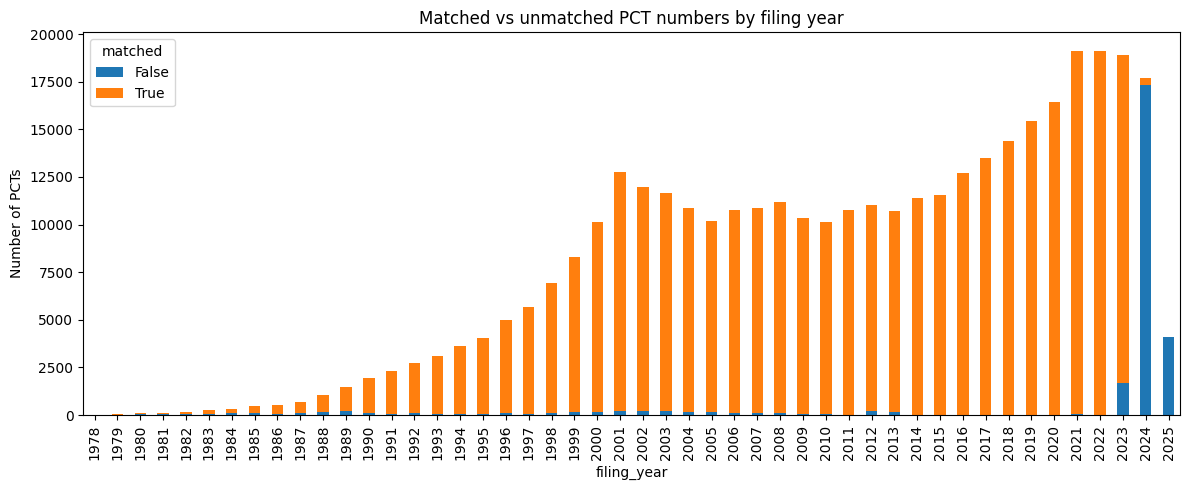

In [17]:
summary.plot(kind='bar', stacked=True, figsize=(12,5))
plt.ylabel('Number of PCTs')
plt.title('Matched vs unmatched PCT numbers by filing year')
plt.tight_layout()

## Inventor-country totals (selected countries)

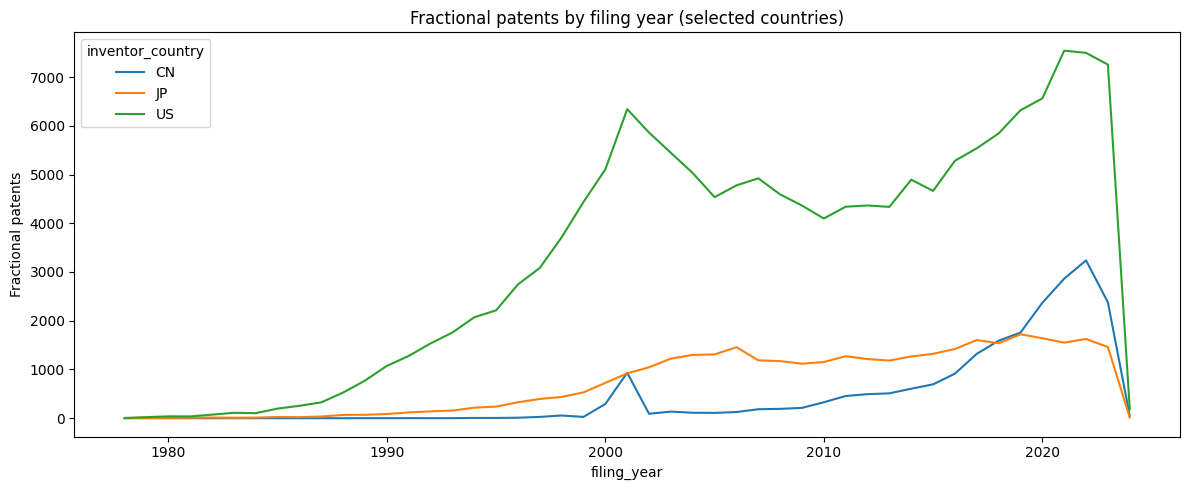

In [18]:
selected = counts[counts['inventor_country'].isin(['CN','US','JP','UK'])]
pivot = selected.pivot(index='filing_year', columns='inventor_country', values='fractional_patents').fillna(0)
pivot.plot(figsize=(12,5))
plt.title('Fractional patents by filing year (selected countries)')
plt.ylabel('Fractional patents')
plt.tight_layout()

## Merge pct/regpat and save CSV

In [20]:
merged = pct.merge(reg[['pct_nbr','ctry_code','inv_share']], on='pct_nbr', how='left', suffixes=('','_reg'))
merged['matched'] = merged['ctry_code'].notna()
merged[['pct_nbr','filing_date','filing_year','ctry_code','inv_share','matched']].to_csv('../data/processed/pct_regpat_merge.csv', index=False)
merged.head()

,pct_nbr,filing_date,filing_year,matched,ctry_code,inv_share
0,WO2019202767,20181127,2018,True,JP,0.500000
1,WO2019202767,20181127,2018,True,JP,0.500000
2,WO1994026925,19940504,1994,True,DK,0.111111
3,WO1994026925,19940504,1994,True,DK,0.111111
4,WO1994026925,19940504,1994,True,DK,0.111111


## Merge pct/regpat and export

In [ ]:
merged = pct.merge(reg[['pct_nbr','ctry_code','inv_share']], on='pct_nbr', how='left', suffixes=('','_reg'))
merged['matched'] = merged['ctry_code'].notna()
export_cols = ['pct_nbr','filing_date','filing_year','ctry_code','inv_share','matched']
merged[export_cols].to_csv('data/processed/pct_regpat_merge.csv', index=False)
merged.head()